# Particle tracking 

We are going to obtain the tracking data from the videos used to measure the potential generated by optical traps forming a ring.
The tracking matrix will be saved as csv files to save computation time in the analysis project.  

In [1]:
#Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import scipy.optimize as opt
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import av

from slicerator import pipeline
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

In [35]:
#Video import to variable container
filePath = r'C:\Users\Eric\Documents\Projects\BASEP\BASEP_tests\20191128\Test55_2019_11_28_20_17_20.avi'
video = pims.open(filePath)
#video = pims.Video(filePath)

C:\Users\Eric\Anaconda3\lib\site-packages\pims\api.py:191: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: list indices must be integers or slices, not av.video.stream.VideoStream
  warn(message)


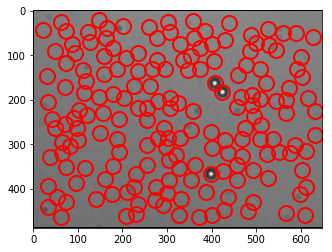

In [36]:
#Show first frame of the video with the particle localization
f = tp.locate(as_gray(video[len(video)-1]), 19, invert=False) #len(video)-1
plt.figure() #make a new figure
tp.annotate(f, as_gray(video[len(video)-1]));

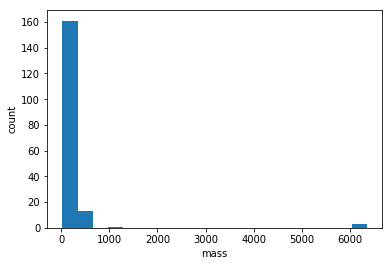

In [37]:
#Histogram of brightness mass to correct the wrong particle localization
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

#label the axes
ax.set(xlabel='mass', ylabel='count');

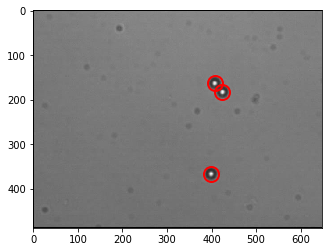

In [38]:
f = tp.locate(as_gray(video[len(video)-1]), 19, invert=False, minmass=4000)
plt.figure()
tp.annotate(f, video[len(video)-1])

In [39]:
#Location of features in all the frames
f = tp.batch(as_gray(video[:]), 19, minmass = 4000, invert=False);

Frame 4269: 3 features


Frame 4269: 3 trajectories present.


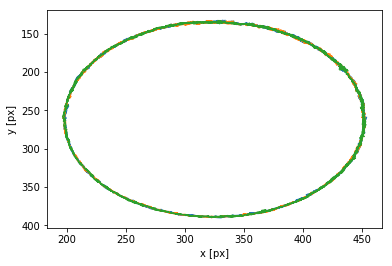

In [40]:
t = tp.link_df(f, 20, memory=60) #Link of trajectories: max displacement = 20, memory 60 frames

#Trace the trajectories
plt.figure()
tp.plot_traj(t);

In [41]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,137.484089,345.148409,6267.971478,3.148057,0.005437,143.563789,27415.0,-0.108476,0,0
1,207.290768,210.338641,5837.868488,3.107251,0.031971,138.856779,26789.0,-0.088970,0,1
2,220.353462,444.657044,6440.365700,3.148627,0.021058,149.447550,26265.0,-0.077330,0,2
3,137.771346,344.226690,6270.973488,3.121305,0.013020,142.508796,27476.0,-0.123356,1,0
4,207.177618,210.291929,5863.973058,3.090608,0.034275,140.162972,26755.0,-0.100274,1,1


In [42]:
t.to_csv("Tracking_Test55_20191128.dat", sep='\t')

# Filtering particles

In [162]:
import support as sp

In [177]:
trj = t
trj = trj.set_index(["frame", "particle"])
trj = trj.sort_index()

trj.head()

y           x         mass      size       ecc  \
frame particle                                                            
0     0         143.148405  312.467201  6661.835478  3.201133  0.038609   
      1         375.670572  357.256842  6557.988159  3.155947  0.019266   
      2         369.932684  277.387867  6589.802656  3.198267  0.041563   
      3         358.031319  255.207960  6229.038273  3.133978  0.029886   
      4         349.184481  406.104642  6413.322242  3.100268  0.021443   

                    signal  raw_mass        ep  
frame particle                                  
0     0         148.867832   27300.0 -0.113655  
      1         149.468105   25796.0 -0.075344  
      2         146.466738   25989.0 -0.078750  
      3         144.065644   25383.0 -0.068961  
      4         150.668652   25421.0 -0.069503

In [178]:
trj = sp.changeToPolarCoordinates(trj)

trj.head()

y          x         mass      size       ecc  \
frame particle                                                           
0     0        -128.894099 -22.170206  6661.835478  3.201133  0.038609   
      1         103.628068  22.619435  6557.988159  3.155947  0.019266   
      2          97.890180 -57.249540  6589.802656  3.198267  0.041563   
      3          85.988816 -79.429447  6229.038273  3.133978  0.029886   
      4          77.141978  71.467236  6413.322242  3.100268  0.021443   

                    signal  raw_mass        ep           r     theta  
frame particle                                                        
0     0         148.867832   27300.0 -0.113655  130.786875 -1.741133  
      1         149.468105   25796.0 -0.075344  106.067975  1.355892  
      2         146.466738   25989.0 -0.078750  113.401928  2.099990  
      3         144.065644   25383.0 -0.068961  117.060298  2.316562  
      4         150.668652   25421.0 -0.069503  105.159167  0.823565

In [179]:
len(trj[trj.r<2*trj.r.mean()].index.get_level_values("particle").unique())

21

In [180]:
new_t = trj[trj.r<2*trj.r.mean()]
new_t = new_t.reset_index()
del new_t["r"], new_t["theta"]
new_t.head()

,frame,particle,y,x,mass,size,ecc,signal,raw_mass,ep
0,0,0,-128.894099,-22.170206,6661.835478,3.201133,0.038609,148.867832,27300.0,-0.113655
1,0,1,103.628068,22.619435,6557.988159,3.155947,0.019266,149.468105,25796.0,-0.075344
2,0,2,97.890180,-57.249540,6589.802656,3.198267,0.041563,146.466738,25989.0,-0.078750
3,0,3,85.988816,-79.429447,6229.038273,3.133978,0.029886,144.065644,25383.0,-0.068961
4,0,4,77.141978,71.467236,6413.322242,3.100268,0.021443,150.668652,25421.0,-0.069503


In [181]:
len(new_t.particle.unique())

21

In [182]:
new_t.to_csv("Tracking_Test37_20191128.dat", sep='\t')